## Testing for data scrabing on Esco and Jobnet

In [ ]:
# Import magics

# !pip install selenium
# !pip install webdriver_manager
# !python -m nltk.downloader popular
# !pip install tensorflow
# !pip install spacy
# !pip install wordloud
# !python -m spacy download da_core_news_md
# !pip install keras

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import re
import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from io import StringIO
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
import spacy
from spacy import displacy
from tensorflow.keras import layers
from spacy.lang.da.stop_words import STOP_WORDS

import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import lemmy
lemmatizer = lemmy.load("da")

from function import *

seed = 42
AUTOTUNE = tf.data.AUTOTUNE
# %load_ext tensorboard

In [ ]:
with open('stopord.txt', encoding='utf8') as f:
    stopord = f.read().splitlines()
stop_word = nltk.corpus.stopwords.words('danish') + stopord

nlp = spacy.load('da_core_news_md')

# Jobindex

## Selecting data on Jobindex

In [ ]:
from queue import Empty

def extract_jobindex(tag, pages):
    flat_list = []
    url_list = []
    total_pages = range(pages)
    headers = {'User-Agent':'kjp538@alumni.ku.dk'}


    for page in total_pages:
        url = f"https://www.jobindex.dk/jobsoegning?maxdate=20220101&mindate=20210101&page={page}&jobage=archive&q={tag}"
                        
        r = requests.get(url, headers)
            
        soup = BeautifulSoup(r.content.decode("utf-8"), "html.parser")
                        
        divs = soup.find_all("div", class_="jobsearch-result")
        
        for item in divs:
            try:
                job_url = item.select_one('[data-click*="u="]:has(> b)')['data-click']
                url_list.append(job_url)
            except:
                pass

        for i in url_list:
            link = 'http://www.jobindex.dk' + i
            flat_list.append(link)

    return flat_list

### Cleaning Jobindex data

In [ ]:
porter = nltk.PorterStemmer()
# nltk.download('omw-1.4')
wnl = nltk.WordNetLemmatizer()

In [ ]:
def lemmatize_text(input):
    list_ = []
    func = [lemmatizer.lemmatize('', i) for i in input]
    for sublist in func:
        list_.append(sublist[:1])

    return list_

def clean_jobindex(search_word):
    final_job = []
    jobindex = []
    info_job = [] 
    flat_list = []
    final_list = []
    job_list = []

    headers = {'User-Agent':'kjp538@alumni.ku.dk'}
    job = extract_jobindex(search_word, 4)
    
    for i in job:
        url = f"{i}"
        r = requests.get(url, headers)
        soup = BeautifulSoup(r.content.decode("utf-8"), "html.parser")
        iframe = soup.find_all('iframe', class_='archive-content')
        for i in iframe:
            link = i['src']
            info_job.append(link)

    for item in info_job:
        links = 'http://www.jobindexarkiv.dk/cgi/showarchive.cgi' + item
        jobindex.append(links)


    for i in jobindex:
        url_ = f"{i}"
        r = requests.get(url_, headers)
        soup = BeautifulSoup(r.content, "html.parser")
        content = soup.find_all('body')
        for i in content:
            text = i.get_text()
            flat_list.append(text)

    job_ = ' '.join(str(i) for i in flat_list)
    _job = nltk.word_tokenize(clean_text(job_))
    job__ = lemmatize_text(_job)
    for sublist in job__:
        job_list.append(' '.join(sublist))

    for word in job_list:
        if word not in stop_word:
            final_job.append(word)

    res = []
    for i in final_job:
        [res.append(i) for i in final_job if i not in res]

    return res


jobindex_psych = clean_jobindex('cand.psych')
jobindex_oecon = clean_jobindex('cand.oecon')
jobindex_pol = clean_jobindex('cand.scient.pol')
jobindex_anth = clean_jobindex('cand.scient.anth')
jobindex_soc = clean_jobindex('cand.scient.soc')

jobindex_psych_full = ' '.join(jobindex_psych)
jobindex_oecon_full = ' '.join(jobindex_oecon)
jobindex_pol_full = ' '.join(jobindex_pol)
jobindex_anth_full = ' '.join(jobindex_anth)
jobindex_soc_full = ' '.join(jobindex_soc)

print(f'Number of word in \n psych: {len(jobindex_psych_full)}, \n oecon: {len(jobindex_oecon_full)}, \n pol: {len(jobindex_pol_full)}, \n anth: {len(jobindex_anth_full)}, \n soc: {len(jobindex_soc_full)}')

### Plotting Jobindex data using Wordcloud

In [ ]:
write_text('cand.oecon', jobindex_oecon)
write_text('cand.psych', jobindex_psych)
write_text('cand.pol', jobindex_pol)
write_text('cand.anth', jobindex_anth)
write_text('cand.soc', jobindex_soc)

def stacy_words(input):
    document = nlp(open(f'{input}', encoding="utf-8").read())
    adjs = []
    for token in document:
       if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
    # adjs_tally = Counter(adjs)
    # adjs_tally.most_common()
        adj = ' '.join(adjs)
    return adj

path = Path('/Users/nicolaibernsen/Desktop/KU/9.Semester/Introduction_to_Social_Datascience/ISDS/Exam/')

oecon_adjs = stacy_words(path / 'cand.oecon.txt')
psych_adjs = stacy_words(path / 'cand.psych.txt')
pol_adjs = stacy_words(path / 'cand.pol.txt')
anth_adjs = stacy_words(path / 'cand.anth.txt')
soc_adjs = stacy_words(path / 'cand.soc.txt')

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_oecon_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_psych_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_psych_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_pol_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_anth_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(jobindex_soc_full)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Importing skills from ESCO

In [57]:
occupations = ['http://data.europa.eu/esco/occupation/99492920-e5a5-4dba-9e5a-93193147198c', 
'http://data.europa.eu/esco/occupation/11df8941-508c-4103-ad40-52cdf9430a59', 
'http://data.europa.eu/esco/occupation/acf69cab-8629-45c8-ae10-c8fb15f474b6', 
'http://data.europa.eu/esco/occupation/52ded7d7-11df-42e3-b90a-d7f4b70fb4b9',
'http://data.europa.eu/esco/occupation/4f89b0d2-b666-4890-af01-25d1d60da1f3']

jobs = pd.DataFrame(columns=['job_title', 'essential_skill', 'optional_skill'])

for i in occupations:
    jobs = jobs.append(fetching_occupation(i))

jobs = jobs.apply(lambda x: x.replace({'økonom':'cand.oecon', 'psykolog':'cand.psych', 'antropolog':'cand.scient.anth', 
'politolog':'cand.scient.pol', 'sociolog':'cand.scient.soc'}, regex=True))

In [71]:
def find_search_words(df, type_):
    search_words = []
    job_list = []
    final_list = []
    searchword = df.loc[jobs['job_title'] == f'{type_}']
    for value in searchword['optional_skill']:
        search_words.append(value)
    for value in searchword['essential_skill']:
        search_words.append(value)
    res = ' '.join(search_words)
    res = nltk.word_tokenize(clean_text(res))
    res_ = lemmatize_text(res)
    for sublist in res_:
        job_list.append(' '.join(sublist))

    for word in job_list:
        if word not in stop_word:
            final_list.append(word)

    result = []
    for i in final_list:
        [result.append(i) for i in final_list if i not in result]

    return result

esco_oecon = find_search_words(jobs, 'cand.oecon')
esco_psych = find_search_words(jobs, 'cand.psych')
esco_pol = find_search_words(jobs, 'cand.scient.pol')
esco_anth = find_search_words(jobs, 'cand.scient.anth')
esco_soc = find_search_words(jobs, 'cand.scient.soc')

print(f'Number of skills in: \n psych: {len(esco_psych)}, \n oecon: {len(esco_oecon)}, \
    \n pol: {len(esco_pol)}, \n anth: {len(esco_anth)}, \n soc: {len(esco_soc)}')

Number of skills in: 
 psych: 30, 
 oecon: 25,     
 pol: 16, 
 anth: 11, 
 soc: 19


In [79]:
def matches(esco, jobindex):
    matches = [x for x in esco if x in jobindex]
    return matches

print('Found the following matches between Esco Skills and skills in Jobindex Data:')
print(f'cand.oecon = {matches(esco_oecon, jobindex_oecon_full)} \n \
cand.psych = {matches(esco_psych, jobindex_psych_full)} \n \
cand.scient.soc = {matches(esco_soc, jobindex_soc_full)} \n \
cand.scient.ant = {matches(esco_anth, jobindex_anth_full)} \n \
cand.scient.pol = {matches(esco_pol, jobindex_pol_full)}')

Found the following matches between Esco Skills and skills in Jobindex Data:
cand.oecon = ['videnskabelig', 'rapportere', 'analysere', 'finansiel', 'analytisk', 'kvantitativ', 'kvalitativ', 'statistik', 'statistisk'] 
 cand.psych = ['psykiatrisk', 'psykiatri', 'social', 'rapportere', 'terapi', 'sundhedsuddannelse', 'styring', 'sundhedspleje', 'terapeutisk'] 
 cand.scient.soc = ['soci', 'videnskabelig', 'statistik', 'kvantitativ', 'data', 'kvalitativ', 'statistisk', 'menneskelig'] 
 cand.scient.ant = ['videnskabelig'] 
 cand.scient.pol = ['analysere', 'soci', 'statistik', 'statistisk', 'videnskabelig', 'politisk']


## Scraping UG

In [ ]:
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]

In [ ]:
# psych = nltk.word_tokenize(extract_UG(education_url[0][0]))
# oecon = nltk.word_tokenize(extract_UG(education_url[1][0]))
# pol = nltk.word_tokenize(extract_UG(education_url[2][0]))
# anth = nltk.word_tokenize(extract_UG(education_url[3][0]))
# soc = nltk.word_tokenize(extract_UG(education_url[4][0]))
# psych_final = []
# for word in psych:
#     if word not in stop_word:
#         psych_final.append(word)

In [ ]:
ku_list = []

search_list = ['psykologi', 'sociologi', 'statskundskab', 'antropologi', 'oekonomi']

for k in search_list:
    soup = extract_ku(k)
    ku_list.append(transform_ku(soup))

ku_df = pd.DataFrame(data=ku_list)

#Merging the two colums 
ku_df=ku_df[0]+ku_df[1]

#Making the object a dataframe
ku_df=pd.DataFrame(ku_df)

ku_df=pd.DataFrame.transpose(ku_df)

ku_df.columns=['cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', 'cand.oecon_ku']
soup = extract_au('statskundskab')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_stats = text[75:77]

stats_df = pd.DataFrame(data=text_stats, columns=['cand.scient.pol_au'])
stats = pd.DataFrame([', '.join(stats_df['cand.scient.pol_au'].to_list())], columns=['cand.scient.pol_au'])
soup = extract_au('oekonomi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_oek = text[60:62]

oek_df = pd.DataFrame(data=text_oek, columns=['cand.oecon_au'])
oek = pd.DataFrame([', '.join(oek_df['cand.oecon_au'].to_list())], columns=['cand.oecon_au'])
soup = extract_au('antropologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_ant = text[50:55]

ant_df = pd.DataFrame(data=text_ant, columns=['cand.scient.anth_au'])
ant = pd.DataFrame([', '.join(ant_df['cand.scient.anth_au'].to_list())], columns=['cand.scient.anth_au'])
soup = extract_au('psykologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_psyk = text[74:78]

psyk_df = pd.DataFrame(data=text_psyk, columns=['cand.psych_au'])
psyk = pd.DataFrame([', '.join(psyk_df['cand.psych_au'].to_list())], columns=['cand.psych_au'])
frames = [ant, stats, psyk, oek]

au_df = pd.concat(frames, axis=1)

au_df_list = au_df['cand.scient.anth_au'].to_list()
au_list = []

for i in au_df_list:
    au_list.append(clean_text(i))

au_list
def transform_aau(soup):

    divs = soup.find_all("main", class_="Main_Main__2KIvG")

    for item in divs:
        text_aau = item.find_all()[0].text.strip()

        aau_text = {
            "text_aau" : text_aau, 
        }
        aau_list.append(aau_text)

        text_aau = clean_text(text_aau)
        
    return text_aau

aau_list = []

search_list = ['psykologi', 'sociologi', 'oekonomi']

for k in search_list:
    try: 
        soup = extract_aau(k)
        transform_aau(soup)
    except:
        break

aau_df = pd.DataFrame(data=aau_list)

aau_df=pd.DataFrame.transpose(aau_df)

aau_df.columns=['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau']

aau_df = aau_df.reset_index(drop=True)

aau_df

## Combining Dataframes
merge_frames = [ku_df, au_df, aau_df]

combined_df = pd.concat(merge_frames, axis=1)

combined_df['cand.psych_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.psych_ku']]
combined_df['cand.scient.pol_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.pol_ku']]
combined_df['cand.oecon_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.oecon_ku']]
combined_df['cand.scient.anth_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.anth_ku']]
combined_df['cand.scient.soc_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.soc_ku']]

combined_df['cand.psych'] = combined_df['cand.psych_aau'] + combined_df['cand.psych_au'] + combined_df['cand.psych_ku_string']
combined_df['cand.scient.anth'] = combined_df['cand.scient.anth_au'] + combined_df['cand.scient.anth_ku_string']
combined_df['cand.scient.pol'] = combined_df['cand.scient.pol_au'] + combined_df['cand.scient.pol_ku_string']
combined_df['cand.scient.soc'] = combined_df['cand.scient.soc_aau'] + combined_df['cand.scient.soc_ku_string']
combined_df['cand.oecon'] = combined_df['cand.oecon_aau'] + combined_df['cand.oecon_au'] + combined_df['cand.oecon_ku_string']
combined_df.drop(['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau', 'cand.psych_au', \
                  'cand.scient.anth_au', 'cand.scient.pol_au','cand.oecon_au', \
                  'cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', \
                  'cand.oecon_ku', 'cand.psych_ku_string', 'cand.scient.pol_ku_string', 'cand.oecon_ku_string', \
                  'cand.scient.anth_ku_string', 'cand.scient.soc_ku_string'], axis=1, inplace=True)
university_df = combined_df
university_df

## Scraping UG
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]
psych = clean_text(extract_UG(education_url[0][0]))
oecon = extract_UG(education_url[1][0])
pol = extract_UG(education_url[2][0])
anth = extract_UG(education_url[3][0])
soc = extract_UG(education_url[4][0])

## Combining skills from UG and Universities
strings_psych = psych + university_df['cand.psych']
strings_oecon = oecon + university_df['cand.oecon']
strings_pol = pol + university_df['cand.scient.pol']
strings_anth = anth + university_df['cand.scient.anth']
strings_soc = soc + university_df['cand.scient.soc']


psych_comb = " ".join(strings_psych)
oecon_comb = " ".join(strings_oecon)
pol_comb = " ".join(strings_pol)
anth_comb = " ".join(strings_anth)
soc_comb = " ".join(strings_soc)
psych_series = pd.Series(psych_comb)
oecon_series = pd.Series(oecon_comb)
pol_series = pd.Series(pol_comb)
anth_series = pd.Series(anth_comb)
soc_series = pd.Series(soc_comb)

psych_df = pd.DataFrame(psych_series)
oecon_df = pd.DataFrame(oecon_series)
pol_df = pd.DataFrame(pol_series)
anth_df = pd.DataFrame(anth_series)
soc_df = pd.DataFrame(soc_series)

psych_df['cand.psych'] = psych_df[0]
oecon_df['cand.oecon'] = oecon_df[0]
pol_df['cand.scient.pol'] = pol_df[0]
anth_df['cand.scient.anth'] = anth_df[0]
soc_df['cand.scient.soc'] = soc_df[0]
final_df = pd.concat([psych_df['cand.psych'], oecon_df['cand.oecon'], pol_df['cand.scient.pol'], \
                      anth_df['cand.scient.anth'], soc_df['cand.scient.soc']], axis=1)

final_df = make_a_list(final_df['cand.psych']).append(make_a_list(final_df['cand.oecon'])).append(make_a_list(final_df['cand.scient.pol']))\
    .append(make_a_list(final_df['cand.scient.anth'])).append(make_a_list(final_df['cand.scient.soc']))

final_df = final_df.T
final_df.columns = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

final_df['cand.psych'] = final_df['cand.psych'].apply(nltk.word_tokenize)
final_df['cand.oecon'] = final_df['cand.oecon'].apply(nltk.word_tokenize)
final_df['cand.scient.pol'] = final_df['cand.scient.pol'].apply(nltk.word_tokenize)
final_df['cand.scient.anth'] = final_df['cand.scient.anth'].apply(nltk.word_tokenize)
final_df['cand.scient.soc'] = final_df['cand.scient.soc'].apply(nltk.word_tokenize)

final_df['cand.psych'] = final_df['cand.psych'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.oecon'] = final_df['cand.oecon'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.pol'] = final_df['cand.scient.pol'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.anth'] = final_df['cand.scient.anth'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.soc'] = final_df['cand.scient.soc'].apply(lambda words: [word for word in words if word not in stop_word])

In [ ]:
def df_to_list(series):
    final_list_ = []
    job_list = []
    for i in series:
        list_ = list(i)
    list_ = ' '.join(list_)
    final_list = list_.split(' ')
    # for word in final_list:
    #     if word not in stop_word:
    #         final_list_.append(word)

    job = lemmatize_text(final_list)
    for sublist in job:
        job_list.append(' '.join(sublist))

    for word in job_list:
        if word not in stop_word:
            final_list_.append(word)
    
    res = []
    for i in final_list_:
        [res.append(i) for i in final_list_ if i not in res]

    return res

udd_oecon_list = df_to_list(final_df['cand.oecon'])
udd_psych_list = df_to_list(final_df['cand.psych'])
udd_pol_list = df_to_list(final_df['cand.scient.pol'])
udd_anth_list = df_to_list(final_df['cand.scient.anth'])
udd_soc_list = df_to_list(final_df['cand.scient.soc'])

udd_oecon_string = ' '.join(udd_oecon_list)
udd_psych_string = ' '.join(udd_psych_list)
udd_anth_string = ' '.join(udd_anth_list)
udd_pol_string = ' '.join(udd_pol_list)
udd_soc_string = ' '.join(udd_soc_list)

### Plot of udd via Wordcloud

In [ ]:
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=100, #Maximum words in the WordCloud
                      colormap='ocean', #Color of the WordCloud
                      mask=mask,
                      background_color='white',
                      stopwords=stop_word, #Setting StopWords equal to the updated
                      collocations=True).generate(data)
    plt.figure(figsize=(10,10))
    plt.imshow(cloud)
    plt.axis('off') #No axis 
    plt.title(title, fontsize=20) #Title
    plt.show()

generate_better_wordcloud(udd_oecon_string, 'Oecon')

In [ ]:
generate_better_wordcloud(udd_psych_string, 'Oecon')

In [ ]:
generate_better_wordcloud(udd_anth_string, 'Oecon')

In [ ]:
generate_better_wordcloud(udd_soc_string, 'Oecon')

In [ ]:
generate_better_wordcloud(udd_pol_string, 'Oecon')

### Tensorflow (Word2Vec)

In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):

  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

def tensorflow_training_data(input):

  text_ds = tf.data.TextLineDataset(f'{input}')

  BATCH_SIZE = 30000

  vocab_size = BATCH_SIZE

  sequence_length = 20

  def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                    '[%s]' % re.escape(string.punctuation), '')

  # Use the `TextVectorization` layer to normalize, split, and map strings to
  # integers. Set the `output_sequence_length` length to pad all samples to the
  # same length.
  vectorize_layer = layers.TextVectorization(
      standardize=custom_standardization,
      max_tokens=vocab_size,
      output_mode='int',
      output_sequence_length=sequence_length,
      pad_to_max_tokens=False,
      ngrams=None,
      vocabulary=None)

  vectorize_layer.adapt(text_ds.batch(BATCH_SIZE))
  inverse_vocab = vectorize_layer.get_vocabulary()

  #Vectorize data
  text_vector_ds = text_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

  sequences = list(text_vector_ds.as_numpy_iterator())
  print(len(sequences))
  for seq in sequences[:10]:
    print(f'{seq} => {[inverse_vocab[i] for i in seq]}')

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=seed)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

tensorflow_training_data('cand.pol.txt')

### Vectorizing words with TfidfVectorizer

In [ ]:
def find_words(words_to_search, list_, name):
    for i in words_to_search:
        if i in list_:
            print(f'{i} is present in the list of {name}')

find_words(esco_oecon, jobindex_oecon, 'oecon')
find_words(esco_anth, jobindex_anth, 'anth')
find_words(esco_pol, jobindex_pol, 'pol')
find_words(esco_psych, jobindex_psych, 'psych')
find_words(esco_soc, jobindex_soc, 'soc')

In [ ]:
def make_vectorizer(input_udd, input_jobindex):
    list_ = []
    _list = []
    vector = TfidfVectorizer(lowercase=False)
    analyzer = ([input_udd] + [input_jobindex]) #The order does not make a difference here
    ret = vector.fit_transform(analyzer)
    pairwise_similarity = ret * ret.T
    array = pairwise_similarity.toarray()
    for cell in np.nditer(array):
        if cell < 0.9 and cell > 0.001:
            list_.append(cell)
    list_ = list_[1].tolist()

    euclid = euclidean_distances(ret)
    for cell in np.nditer(euclid):
        if cell > 0.1:
            _list.append(cell)
    _list = _list[1].tolist()

    return list_, _list

list_ = (make_vectorizer(udd_oecon_string, jobindex_oecon_full), 
make_vectorizer(udd_psych_string, jobindex_psych_full), 
make_vectorizer(udd_pol_string, jobindex_pol_full), 
make_vectorizer(udd_soc_string, jobindex_soc_full),
make_vectorizer(udd_anth_string, jobindex_anth_full))

df_sim = pd.DataFrame(list_)

df_tfidf = df_sim.rename(index={0:'cand.oecon', 1:'cand.psych', 2:'cand.scient.pol', 3:'cand.scient.soc', 4:'cand.scient.anth'})
df_tfidf.columns=['Tfidf: Cosine Similarity', 'Tfidf: Euclidean Distance']

### Finding similarities with Spacy

In [ ]:
oecon_udd_nlp = nlp(udd_oecon_string)
soc_udd_nlp = nlp(udd_soc_string)
anth_udd_nlp = nlp(udd_anth_string)
psych_udd_nlp = nlp(udd_psych_string)
pol_udd_nlp = nlp(udd_pol_string)

oecon_job_nlp = nlp(jobindex_oecon_full)
soc_job_nlp = nlp(jobindex_soc_full)
anth_job_nlp = nlp(jobindex_anth_full)
psych_job_nlp = nlp(jobindex_psych_full)
pol_job_nlp = nlp(jobindex_pol_full)

print(f'cand.oecon similarity: {oecon_job_nlp.similarity(oecon_udd_nlp)} \n \
cand.soc similarity: {soc_job_nlp.similarity(soc_udd_nlp)} \n \
cand.anth similarity: {anth_job_nlp.similarity(anth_udd_nlp)} \n \
cand.psych similarity: {psych_job_nlp.similarity(psych_udd_nlp)} \n \
cand.pol similarity: {pol_job_nlp.similarity(pol_udd_nlp)}')

### Vectorizing words with Bert

In [ ]:
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

def bert_model_simmilarities(udd_list, jobindex_list):
    list_ = []
    document_embeddings = sbert_model.encode([udd_list, jobindex_list])
    similarities = cosine_similarity(document_embeddings)
    for cell in np.nditer(similarities):
        if cell < 0.9 and cell > 0.1:
            list_.append(cell)

    return list_[1].tolist()

def bert_model_differences(udd_list, jobindex_list):
    list_ = []
    document_embeddings = sbert_model.encode([udd_list, jobindex_list])
    differences = euclidean_distances(document_embeddings)

    for cell in np.nditer(differences):
        if cell > 0.1:
            list_.append(cell)

    return list_[1].tolist()

arr_oecon = bert_model_differences(udd_oecon_list, jobindex_oecon)
arr_oecon_2 = bert_model_simmilarities(udd_oecon_list, jobindex_oecon)

arr_psych = bert_model_differences(udd_psych_list, jobindex_psych)
arr_psych_2 = bert_model_simmilarities(udd_psych_list, jobindex_psych)

arr_pol = bert_model_differences(udd_pol_list, jobindex_pol)
arr_pol_2 = bert_model_simmilarities(udd_pol_list, jobindex_pol)

arr_soc = bert_model_differences(udd_soc_list, jobindex_soc)
arr_soc_2 = bert_model_simmilarities(udd_soc_list, jobindex_soc)

arr_anth = bert_model_differences(udd_anth_list, jobindex_anth)
arr_anth_2 = bert_model_simmilarities(udd_anth_list, jobindex_anth)

list_ = (arr_oecon, arr_psych, arr_pol, arr_soc, arr_anth)
_list = (arr_oecon_2, arr_psych_2, arr_pol_2, arr_soc_2, arr_anth_2)

df_diff = pd.DataFrame(list_)

df_sim = pd.DataFrame(_list)

df_bert = pd.concat([df_diff, df_sim], axis=1)
df_bert = df_bert.rename(index={0:'cand.oecon', 1:'cand.psych', 2:'cand.scient.pol', 3:'cand.scient.soc', 4:'cand.scient.anth'})
df_bert.columns=['Bert: Euclidean Distance', 'Bert: Cosine Similarity']

### Combining all data

In [ ]:
df = pd.concat([df_bert, df_tfidf], axis=1)

In [ ]:
df

### Plotting words

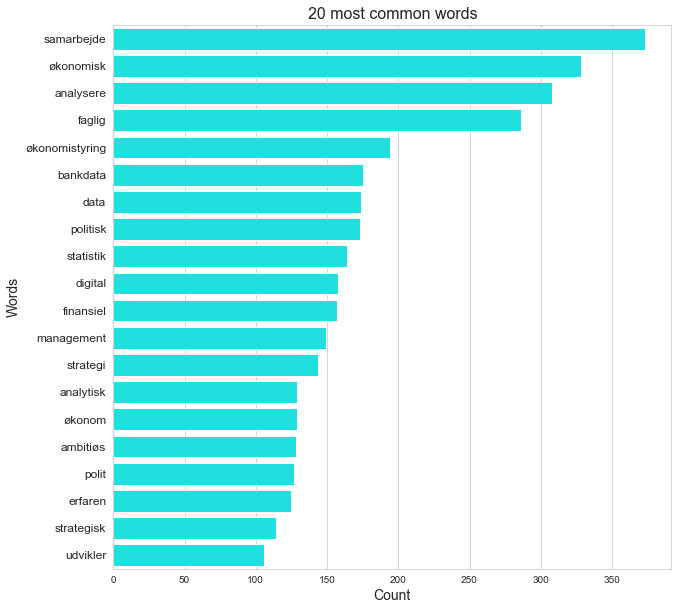

In [72]:
from nltk import FreqDist

jobindex_oecon_plot = FreqDist(jobindex_oecon).most_common(20)

all_fdist = pd.Series(dict(jobindex_oecon_plot))

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,10))

all_plot = sns.barplot(x=all_fdist.values, y=all_fdist.index, ax=ax, color='cyan', ci=None)

plt.ylabel('Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.title('20 most common words', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12) #rotation=30

plt.show()